In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import joblib

from src.data.make_data import create_bins
from src.visualizations.plots import plot_churn_metrics
from src.models.evaluate import calculate_segment_value, plot_threshold_analysis_grid

In [2]:
# Load data
df_raw = pd.read_csv('../data/raw/raw_data.csv')

In this notebook our goal is to identify segments of the customer base deemed to be high value. More precisely we will:
1. Find segments that can be identified using simple rule-based decisions.
2. Evaluate the performance our predictive model with respect to this metric.

We first make precise what we mean by the value of a segment of the customer base. Specifically we define the value of a segment of the population as the ratio
$$
\text{Value of the Segment} = \frac{\text{\% Churned Balance from the Segment}}{\text{\% Population in the Segment}}.
$$
A high value segment, say value > 2, indicates that one would recover atleast twice the amount of churned balance when targeting that segment compared to a random targeting of a group of customers of the same size.

In [3]:
# Baseline churne metrics
total_churned_balance = df_raw[df_raw['Exited'] == 1]['Balance'].sum()
overall_churn_rate = df_raw['Exited'].mean()
print(f"Total balance lost to churn: {total_churned_balance}")
print(f"Overall churn rate: {100*overall_churn_rate:.2f}%")

Total balance lost to churn: 185588094.63
Overall churn rate: 20.37%


# Rule-Based

In [4]:
# Create bins for numerical values
bins_dict = {
    'Age': [-float("inf"), 30, 40, 50, 60, 70, float("inf")],
    'CreditScore': [-float("inf"), 579, 669, 739, 799, float("inf")],
    'Balance': [-float("inf"), 0, 100000, 125000,150000, float("inf")],
}

labels_dict = {
    'Age': ['<30', '30-40', '40-50', '50-60', '60-70', '>70'],
    'CreditScore': ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'],
    'Balance': ['0', '1-100K', '100K-125K', '125K-150K', '>150K'],
}

df_binned = create_bins(df_raw, bins_dict, labels_dict)
df_binned

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_binned,CreditScore_binned,Balance_binned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,40-50,Fair,0
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,40-50,Fair,1-100K
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,40-50,Poor,>150K
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,30-40,Good,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,40-50,Excellent,125K-150K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,30-40,Very Good,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,30-40,Poor,1-100K
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,30-40,Good,0
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,40-50,Very Good,1-100K


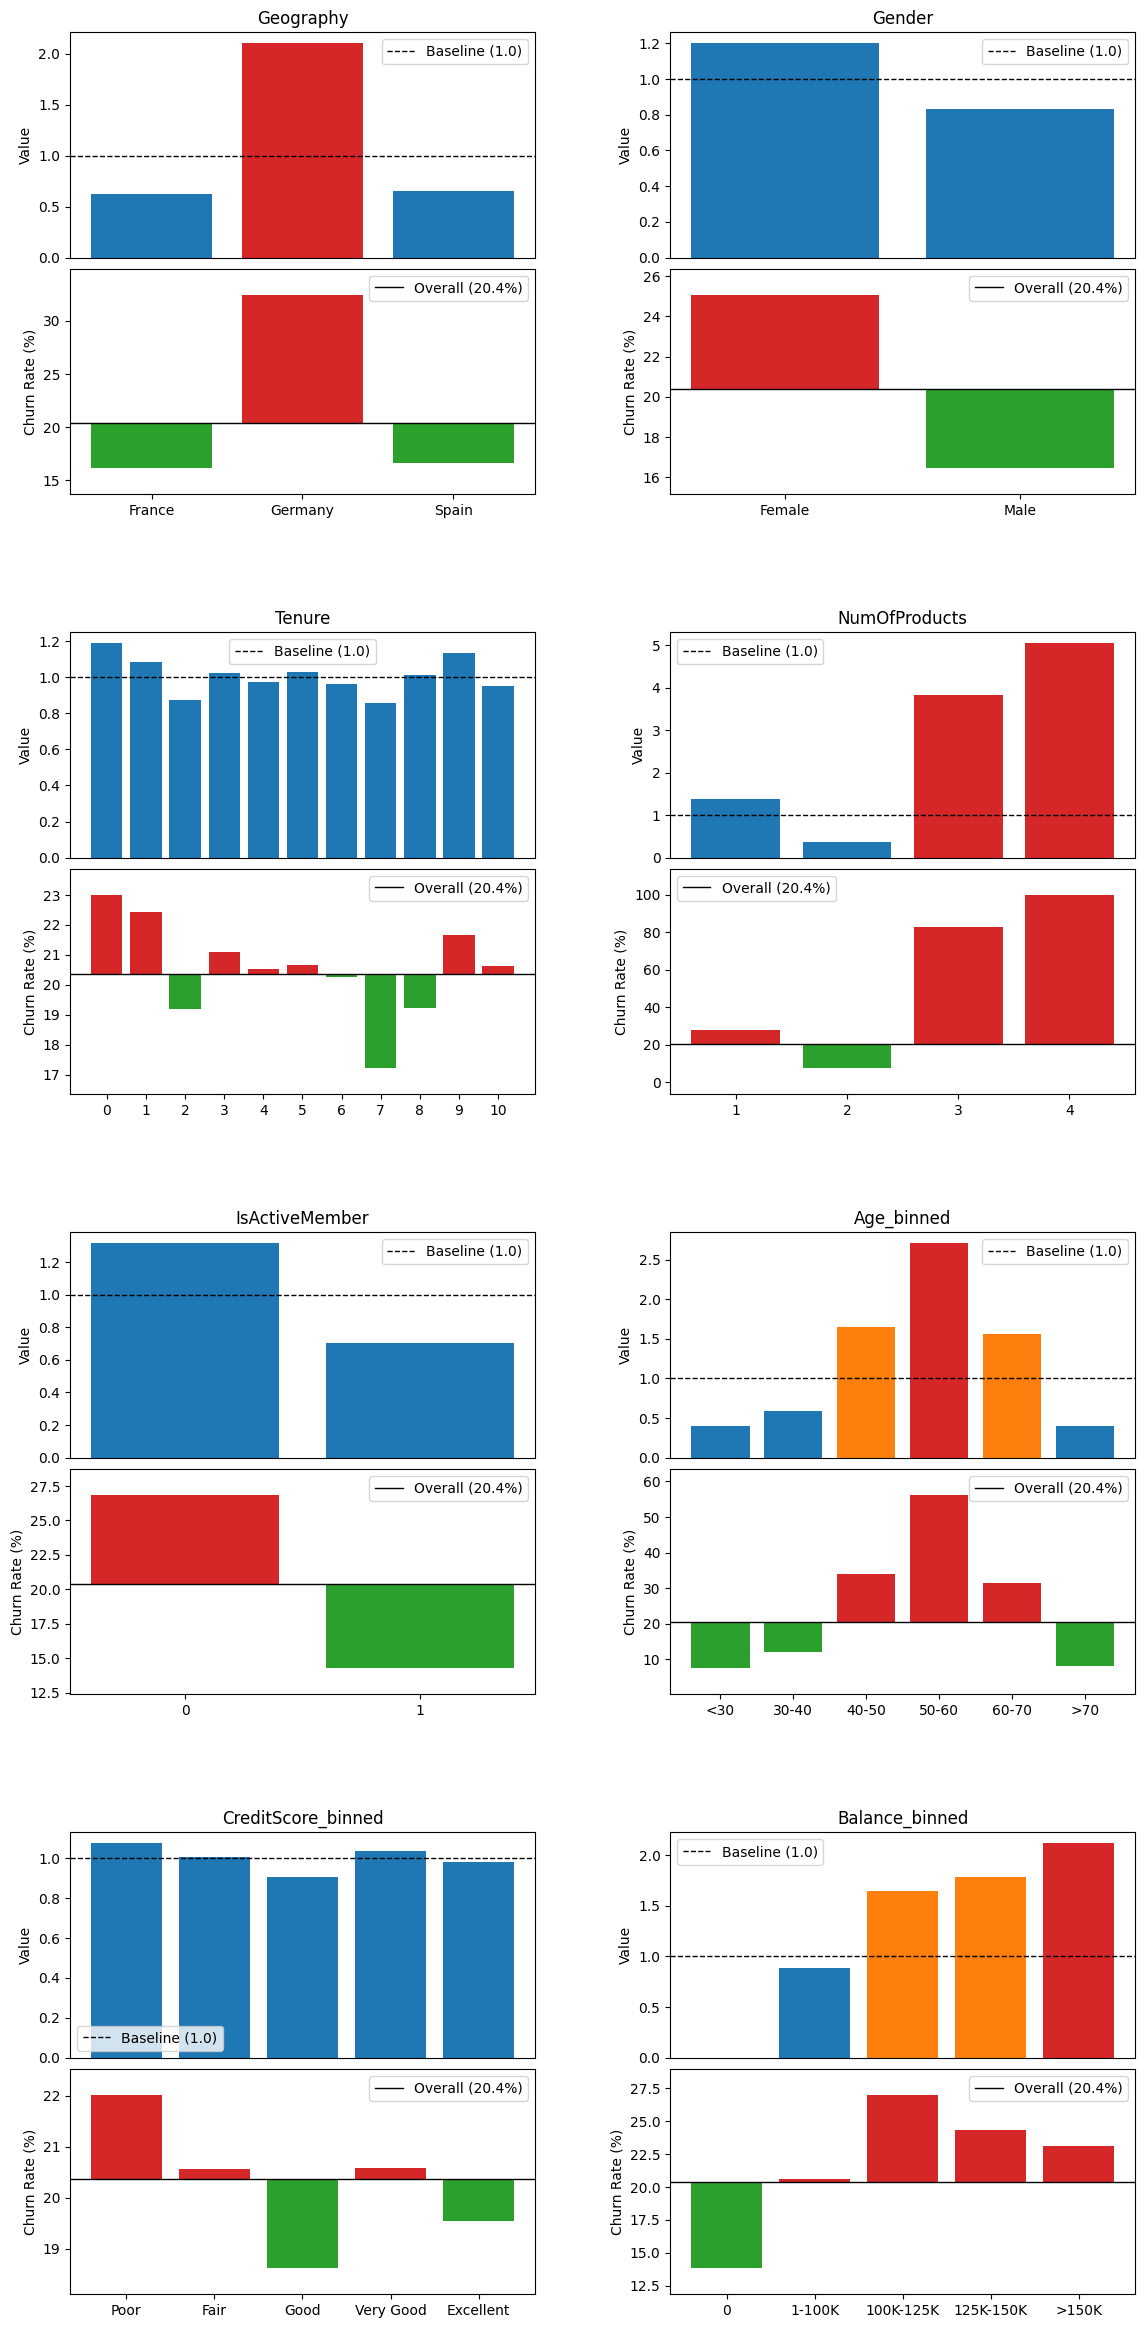

In [5]:
bin_features = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'IsActiveMember', 'Age_binned', 'CreditScore_binned', 'Balance_binned']
fig = plt.figure(figsize=(12, 6*4))

subfigs = fig.subfigures(4, 2, hspace=0.0005, wspace=0.0005)

for i, feature in enumerate(bin_features):
    subfig = subfigs[i // 2, i % 2]
    axes = subfig.subplots(2, 1)
    plot_churn_metrics(feature, df_binned, axes[0], axes[1])
    subfig.subplots_adjust(hspace=0.05)


plt.show()

Segments which are both of high value and churn rate are good targets for reducing churners as retaining these churners will provide a higher return in balance than average as well as less resources wasted on converting customers who are already staying.
- **Customers with 4 or 3 products respectively**
- **Customers in the age bracket 50-60**
- **German based customers**

For segments which are of high or above average value but have lower churn rates, there is a lower return (compared to the above) when retaining as well as a higher risk of using resource on customers who are not churning. Instead these should be indicators that can be combined when deciding when to reach out to customers.
- Customers with balance of >100K
- Customers in the age brackets 40-50, 60-70

In [6]:
# Churn rate and value of Customers with balance >100K and age bracket 40-50 or 60-70
combo_segment = (df_binned['Balance_binned'].isin(['100K-125K', '125K-150K', '>150K'])) & (df_binned['Age_binned'].isin(['40-50', '60-70']))

print(f"Value (Combo): {calculate_segment_value(df_binned, combo_segment):.3f}")
print(f"Churn rate (Combo): {100*(df_binned[combo_segment]['Exited'].mean()):.2f}%")

Value (Combo): 2.795
Churn rate (Combo): 39.60%


We see that customers who fall into both of these less indicative customer base are of high value and churn rate.

In [7]:
# Churn rate and value of Customers to be targeted
target_segment = (df_binned['NumOfProducts'] >= 3) | (df_binned['Age_binned'] == '50-60') | (df_binned['Geography'] == 'Germany') | ((df_binned['Balance_binned'].isin(['100K-125K', '125K-150K', '>150K'])) & (df_binned['Age_binned'].isin(['40-50', '60-70'])))

print(f"Value (Target): {calculate_segment_value(df_binned, target_segment):.3f}")
print(f"Churn rate (Target): {100*(df_binned[target_segment]['Exited'].mean()):.2f}%")
print(f"Population Size (%): {100*sum(target_segment)/len(df_binned)}%")

Value (Target): 2.085
Churn rate (Target): 35.77%
Population Size (%): 39.14%


# Predictive Model

In [8]:
# Load final model and unseen data set
model = joblib.load("../pipelines/final_model.joblib")

df_test = pd.read_csv("../data/clean/test.csv")
X_test, y_test = df_test.drop(['Exited'], axis=1), df_test['Exited']

For our model the class of predicted churners depend on the threshold chosen. We plot the value of the resulting class against the threshold.

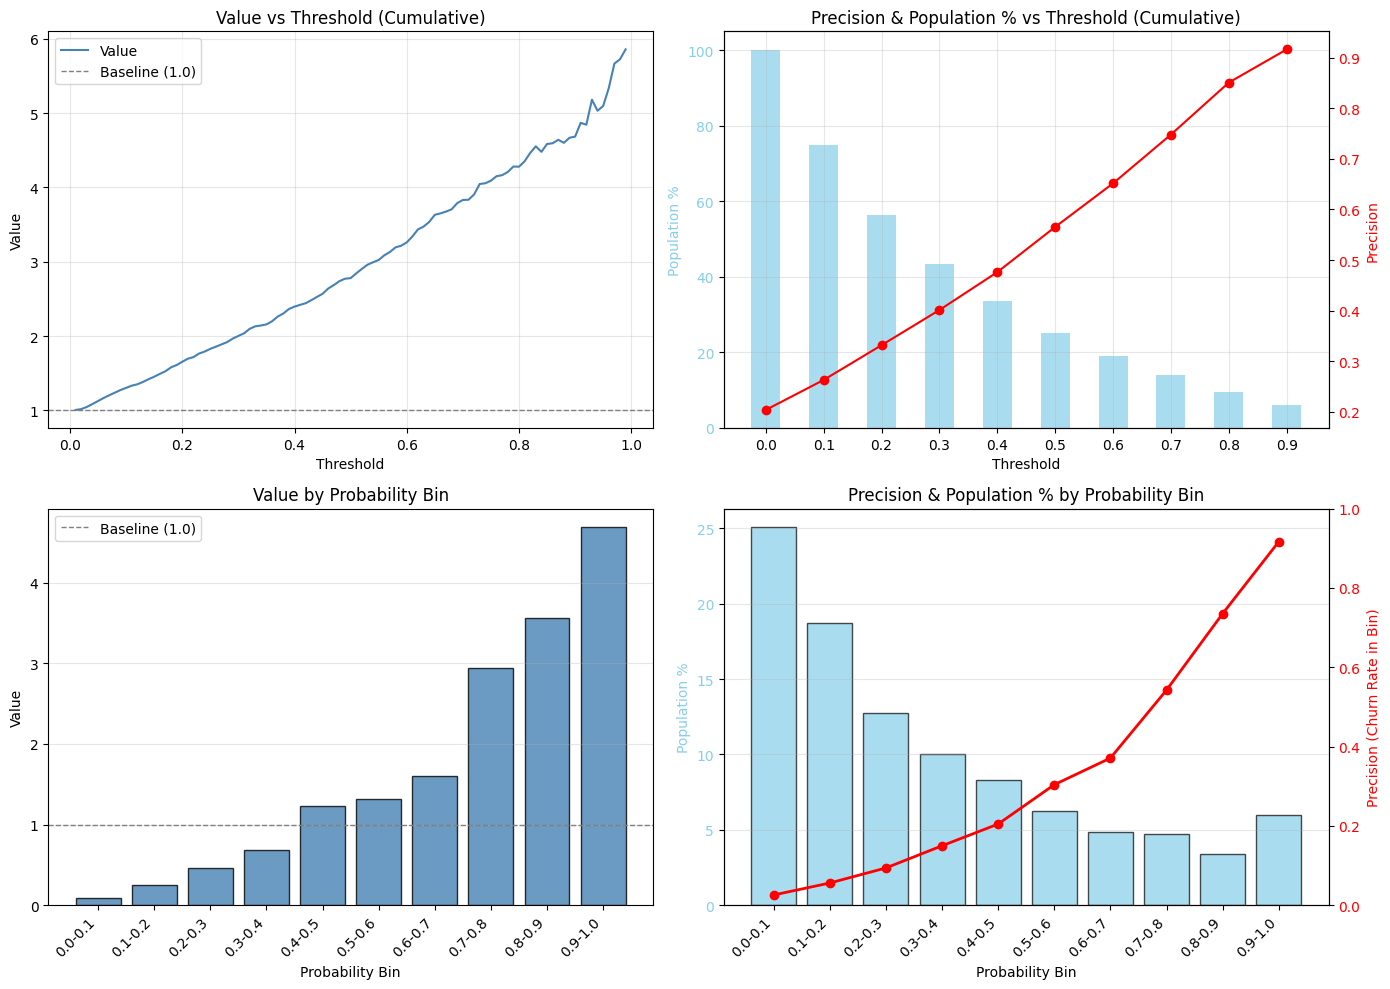

In [9]:
# Predict class probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate value and precision vs threshold plot
plot_threshold_analysis_grid(X_test, y_test, y_pred_proba)

- At a threshold of 0.3, we see that the number of customers predicted to be churners is slightly above the segement determine by rule-based heuristics as well as similar value. However we see that our model has about a 5% improvement in precision compared to the rule-based strategy. 
- In general we see that as we increase the threshold for our model the value and precision of both the resulting cummulative and binned segment of predicted customers increases.